### GASS UVW

Notebook to test the uv coverage computation for an observation with a radio interferometer.

In [93]:
using Distances , Random 
using PyCall
using DataFrames
using LinearAlgebra
using LsqFit
using FFTW

using StatsBase

import CSV 

#rootdir = "/home/stephane/alma/ArrayConfig/GASS"
rootdir = "/home/stephane/Science/ALMA/ArrayConfig/GASS"

push!(LOAD_PATH,"$rootdir/master/src")
using GASS

import PyPlot

@pyimport astropy.coordinates as coord
@pyimport astropy.modeling.models as am
@pyimport astropy.modeling.fitting as mf

@pyimport numpy as np


## directory
datadir = "$rootdir/master/data"
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

### UVW methods

Several to manipulate and analyze uv-coverage in (radio) interferometry. The examples are taken from ALMA, a (sub-) millieter radio interferometer located in the desert of Atacama, Chile

In [94]:
## baseline coordinates
## arr: DataFrames with at least :X, :Y, :Z
## check at https://web.njit.edu/~gary/728/Lecture6.html

function calc_baselines(arr::AbstractDataFrame , lat=-23.0262015)
    
    coordinates= vcat(hcat(convert(Vector{Float64},arr[:X]))' ,
        hcat(convert(Vector{Float64},arr[:Y]))' ,
        hcat(convert(Vector{Float64},arr[:Z]))')
    rot= [0 -sind(lat) cosd(lat) ; 1 0 0 ; 0  cosd(lat)  sind(lat)]
    xyz= *(rot,coordinates)
    
    Nc= size(xyz)
    Nbl= convert(Int64,(Nc[2]*(Nc[2]-1))/2)   
    bl= zeros(Float64,3,2Nbl)   ## symmetry of the bl
    
    ibl= 1
    for i in 1:Nc[2]
        for j in i+1:Nc[2]
            bl[1,ibl]= xyz[1,i]-xyz[1,j] ; bl[1,ibl+Nbl]= xyz[1,j]-xyz[1,i]
            bl[2,ibl]= xyz[2,i]-xyz[2,j] ; bl[2,ibl+Nbl]= xyz[2,j]-xyz[2,i]
            bl[3,ibl]= xyz[3,i]-xyz[3,j] ; bl[3,ibl+Nbl]= xyz[3,j]-xyz[3,i]
            ibl += 1
        end
    end
    return(bl)
end

####
##  bl: baselines computed in calc_baselines
### h0: hour angle in degrees
### d0: source declination in degrees
function calc_uv(bl, h0, d0)
    
    proj= [sind(h0) cosd(h0) 0 ; -sind(d0)cosd(h0) sind(d0)sind(h0) cosd(d0) ; cosd(d0)cosd(h0) -cosd(d0)sind(h0) sind(d0)]
    uv= *(proj, bl)
    return(uv)
end

function calc_uv_coverage
    ## will compute the uv_coverage with an observing and sampling time ..
    ## for now only a snapshot.
end

calc_uv_coverage (generic function with 0 methods)

In [95]:
## Compute properties of a given UV coverage.
## a first shot is by using numpy
function mgrid(xsize, ysize)
    xx= []
    for i in 0:xsize
        push!(xx,fill!(zeros(Int64,xsize+1),i))
    end
    
    yy= []
    for j in 0:ysize
        push!(yy,collect(0:ysize))
    end
    
    println(size(xx))
    println(size(yy))
    return(xx,yy)
end

function pyuv_beamproperties(uv; npix=512, sizefit=60)
    lmax= maximum(abs.(uv))
    dx= 2lmax  / npix
    binx= range(-lmax,stop=lmax,length=npix)
    ds = dx / (299792458.0 / (100 * 1e9))
    dr= 180*3600/(π*npix*ds)   ## arcsec
    gaussian_sigma_to_fwhm=2.3548200450309493

    H, xd, yd = np.histogram2d(uv[1,:], uv[2,:], bins=(collect(binx), collect(binx)))
    
    ## appl ying Briggs weighting with a Robust parameter of 0.5
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H.>0].^2)/Hsum
    f2= (5*10^0.5)^2 * H2sum
    H2 = H ./ (1 .+ f2 .* H)
    
    h = np.fft[:fft2](H2)
    hshift = abs.(real.(np.fft[:fftshift](h)))
    
    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    
    x, y = mgrid(sizefit, sizefit)
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    p_init = am.Gaussian2D(amplitude=maximum(hshiftcut),x_mean=sizefit/2, y_mean=sizefit/2,
        x_stddev=1, y_stddev=1)
    
    fit_p = mf.LevMarLSQFitter()
    p = fit_p(p_init, x, y, hshiftcut, maxiter=100)
    println(p)
    println(p[:x_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:y_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:theta]*180/π)
    
    return(hshiftcut)
end



pyuv_beamproperties (generic function with 1 method)

In [96]:
###################################
function pyuv_beampropertiesTEST(uv; npix=512, sizefit=60)
    lmax= maximum(abs.(uv))
    dx= 16lmax  / npix
    binx= range(-8lmax,stop=8lmax,length=npix)
    ds = dx / (299792458.0 / (100 * 1e9))
    println(dx*npix)
    dr= 180*3600/(π*npix*ds)   ## arcsec
    gaussian_sigma_to_fwhm=2.3548200450309493

    H, xd, yd = np.histogram2d(uv[1,:], uv[2,:], bins=(collect(binx), collect(binx)))
    
    ## appl ying Briggs weighting with a Robust parameter of 0.5
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H .> 0].^2)/Hsum
    
    println(size(H))
    for i in 1:252
        for j in 1:252
            if H[i,j] > 0
                #H[i,j]= 1
            end
        end
    end
    
    R= 0.5
    f2= (5 * 10.0^(-R))^2 * H2sum 
    H2 = H ./ (1 .+ f2 .* H)
    
    #R= -20
    #f2= (5 * 10.0^(-R))^2 * H2sum 
    #H3 = H ./ (1 .+ f2 .* H)

    #h = np.fft[:fft2](H2)
    h= fft(H2)
    
    # hshift = abs.(real.(np.fft[:fftshift](h)))
    hshift= fftshift(abs.(real.(h)))
 
    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    
    x, y = mgrid(sizefit, sizefit)
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    p_init = am.Gaussian2D(amplitude=maximum(hshiftcut),x_mean=sizefit/2, y_mean=sizefit/2,
        x_stddev=1, y_stddev=1)
    
    fit_p = mf.LevMarLSQFitter()
    p = fit_p(p_init, x, y, hshiftcut, maxiter=100)
    println(p)
    println(p[:y_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:x_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:theta]*180/π)
    
    return(hshiftcut)
end


pyuv_beampropertiesTEST (generic function with 1 method)

In [97]:
################################
## setup the npix,fov, freq, etc for the beam extraction from the uv
## coverage. It is based on the uniform weighting 2/FOV for the uv-cell
##
function calc_uvgridWeight(uv, npix=255, sizefit=63)
    println("## UV gridding and weighting...")
    c= 299792458.0  ; ν= 100*1e9 ; λ= c / ν
    D= 12 ; PB= 1.13 * λ / D
    println(PB*180*3600 / π)
    duv= 2/PB/npix
    lmax= maximum(abs.(uv))
    
    if (duv*npix/2) < lmax
        println("##UV-gridding error, npix too small...")
    end
    
    binuv= range(-duv*npix/2, stop=duv*npix/2,npix, length=npix)
    
    Hh= fit(Histogram, (uv[1,:] , uv[2,:]) , (binuv , binuv))
    H= Hh.weights
    
    ## Robust weighting R (Briggs)
    ## R=-2 : uniform
    ## R=2 : naturañ
    ## R=0.5 : "briggs"
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H .> 0].^2)/Hsum
    R= 0.5
    f2= (5 * 10.0^(-R))^2 * H2sum 
    H2 = H ./ (1 .+ f2 .* H)
 
    h= fft(H2)
    hshift= fftshift(abs.(real.(h)))
    
    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    
    x, y = mgrid(sizefit, sizefit)
    println(x)
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    
    println("###")
    return(hshiftcut)
end


calc_uvgridWeight (generic function with 3 methods)

In [98]:
## fitting of the Gaussian 2D for the beam
##

function gaussian2D(x,y, amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
    a = (cosd(theta)**2)/(2*sigma_x**2) + (sind(theta)**2)/(2*sigma_y**2)
    b = -(sind(2*theta))/(4*sigma_x**2) + (sind(2*theta))/(4*sigma_y**2)
    c = (sind(theta)**2)/(2*sigma_x**2) + (cosd(theta)**2)/(2*sigma_y**2)
    gauss2d= offset + amplitude*exp( -(a*((x-xo)^2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)^2)))

    return(gauss2d)
end

function fit_beam(beam, x , y)
    @. multimodel(x, p) = gaussian2D(x[:,1], x[:,2], p[1], p[2] , p[3] , p[4] , p[5], p[6] , p[7])
    
    p0 = [maximum(beam) , 0 , 0 , 1, 1, 0, 0]
    fit = curve_fit(multimodel, xdata, ydata, p0)
     
    return(fit)
end

LoadError: syntax: use "^" instead of "**"

## Input Parameters for GASS 
## Configuration file: ../master/data/O-3.cfg 
## Obs. Latitude: -23.026 
## Source Declination: -50.0 
## HA: -1.0 
## Subarray number: 4 
## UV gridding and weighting...
58.22949632332764
(254,)
(254,)


Any[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 

 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 3

40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41

 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51], [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5

61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61], [62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62

 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71], [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7

81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81], [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82

 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92], [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 9

, 101, 101, 101, 101, 101, 101, 101], [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 1

 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111], [112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 11

, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119], [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 1

 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132], [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 13

, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140], [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 1

, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153

 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,

 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174], [175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 17

, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182], [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 1

 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196,

, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204

 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217], [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 21

, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225], [226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 2

, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238], [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 2

 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246], [247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 24

3901.9939129599998
(254, 254)
(254,)
(254,)
PyObject <Gaussian2D(amplitude=1156.75612614, x_mean=127., y_mean=127., x_stddev=7.0230377, y_stddev=9.99443864, theta=-1.58639519)>

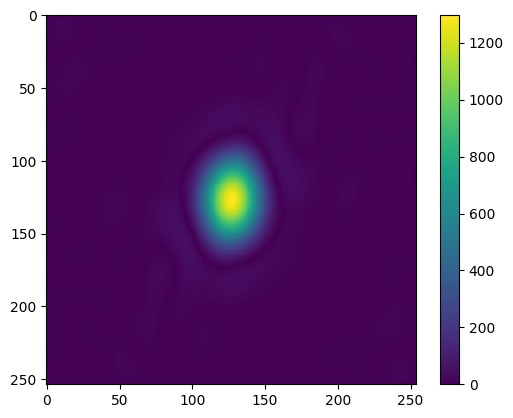


PyObject 3.729712692304337
PyObject 2.6208488353535606
PyObject -90.8937491867379


In [99]:
### Main
macro main(inpfile)
    cfg = read_cfg(inpfile , verbose=true)
    
    ## array test
    bl= calc_baselines(cfg.arr)
    # uv= calc_uv(bl, 0.0,  cfg.obs.Source_Declination)
    uv= calc_uv(bl, 0.0, 30)
    h=  calc_uvgridWeight(uv , 255, 253)
    dirty= pyuv_beampropertiesTEST(uv , npix=255, sizefit=253)
    
    PyPlot.imshow(h)
    PyPlot.colorbar()
    
    # PyPlot.plot(uv[1,:],uv[2,:], "b.")
    PyPlot.show()
    
end

@main("../master/data/GA_Inputs_O-3.txt.julia")